In [1]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00


In [2]:
import textwrap
import json
import random
from pprint import pprint
import operator

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from dataclasses import dataclass
from pydantic import BaseModel, field_validator, ValidationError

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage, BaseMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display, Markdown

from google.colab import userdata
import getpass
import os

# Basics

In [ ]:
# getting api key for gemini
google_api_key = userdata.get('GOOGLE_API_KEY')

#initiating a gemini model
gemini: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                                                        api_key=google_api_key)

# prompt message that has role of human message (a message from human)
prompt: HumanMessage = HumanMessage(content='Hello! What is your name?', name='Gemini')

messages = [prompt]

#checking gemini response
gemini.invoke(messages).content

"I don't have a name. I am a large language model, and I am not a person. 😊 \n"

We can also integrate tools with LangGraph agents and Langchain applications. Here, we will use Tavily Search

In [ ]:
# tavily_api_key = userdata.get('TAVILY_API_KEY')

# # initializing a tavily search instance. We will get top 3 results in response
# tavily_search: TavilySearchResults = TavilySearchResults(max_results=3)

# # invoking the tavily search instance
# tavily_search.invoke('What is temperature in Peshawar?')

# Hello LangGraph

LangGraph is a library for building stateful, multy-actor applications with LLM's, used to create agent and multi-agent workflows

Key features include


*   Implement loops and condition on your agent workflow
*   Automatically save state after each step in the graph. Pause and resume graph execution at any point
*   Interupt graph execution to get approval of human, or allow human to edit next action planned by agent
*   Stream output



Key components include
*  **State** (input schema for all nodes and edges in the graph)
*  **Nodes** (python functions that encodes logic of agents. Recieves current State as input, perform some computation and return an updated State)
* **Edges** (python function that determine which Node to be executed based on the current State)
  * *Normal Edge* (Go directly from one node to the next)
  * *Conditional Edge* (Calls a function to determine which nodes to go to next)




Below is an example of simple LangGraph agent that reflects the basic steps required to create an agent and define a workflow for the agent

In [ ]:
#Defining state
class LearningState(TypedDict):
    prompt: str

In [ ]:

def node_1(state: LearningState) -> LearningState:
    print("---Node 1 State---", state)
    return {"prompt": state['prompt'] +" I am"}

def node_2(state: LearningState) -> LearningState:
    print("---Node 2 State---", state)
    return {"prompt": state['prompt'] +" happy!"}

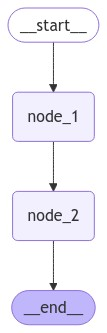

In [ ]:
#initializing graph instance
builder: StateGraph = StateGraph(state_schema=LearningState)

#adding nodes to the graph
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

#adding edges to the graph
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

#compulting the graph
graph: CompiledStateGraph = builder.compile()

#displaying the agent graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"prompt" : "Hi"})

---Node 1 State--- {'prompt': 'Hi'}
---Node 2 State--- {'prompt': 'Hi I am'}


{'prompt': 'Hi I am happy!'}

## Simple Agents

The above code showcase how the state flows through the agent and how it changes. Now, we will integrate LLM with the agent and see how it fares

In [ ]:
google_api_key = userdata.get('GOOGLE_API_KEY')

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                                                    api_key=google_api_key)

class State(TypedDict):
    prompt: str
    response: str

# creating node
def node_1(state: State):
    print("---Node 1 State---", state)
    prompt = state["prompt"]
    print(f"Prompt: {prompt}")

    ai_msg: AIMessage = llm.invoke(prompt)
    return {"prompt": prompt, "response": ai_msg.content}

# building graph
builder: StateGraph = StateGraph(state_schema=State)

# defining nodes of the graph
builder.add_node("node_1", node_1)

# adding edges to the graph
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# compiling graph
graph: CompiledStateGraph = builder.compile()


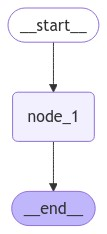

In [ ]:
# Viewing graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"prompt" : "Motivate me to learn LangGraph"})

---Node 1 State--- {'prompt': 'Motivate me to learn LangGraph'}
Prompt: Motivate me to learn LangGraph


In [ ]:
def to_markdown(text)-> Markdown:
    text : str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [ ]:
to_markdown(result['response'])

> ## Why Learn LangGraph? 
> 
> LangGraph isn't just another language model; it's a **powerful tool** that can unlock exciting possibilities in various domains. Here's why learning it could be a game-changer for you:
> 
> **1.  Unlocking the Power of Knowledge Graphs:** 
> 
> * LangGraph lets you **build and query knowledge graphs** with ease.  Imagine a world where you can ask complex questions and get precise, insightful answers from a structured knowledge base.
> * This opens up opportunities in **natural language processing, data analysis, and semantic search**, making it a valuable skill for anyone working with large datasets.
> 
> **2.  Boosting Your NLP Capabilities:**
> 
> * LangGraph is built on **Transformers**, the cutting-edge technology driving advancements in NLP.  This means you'll gain hands-on experience with the most powerful language models available.
> * Learn how to **fine-tune LangGraph for specific tasks**, making it a personalized tool for your unique needs.
> 
> **3.  Expanding Your Career Horizons:**
> 
> *  Knowledge graph technology is rapidly gaining traction, making LangGraph a **highly sought-after skill** in various industries.
> * From **research and development** to **business intelligence and data analysis**, LangGraph opens doors to exciting career opportunities.
> 
> **4.  Empowering Your Creativity:**
> 
> * LangGraph is **highly customizable**, allowing you to tailor it to your specific creative projects. 
> *  Imagine building **interactive stories, personalized chatbots, or innovative search engines** with the power of knowledge graphs at your fingertips.
> 
> **5.  Joining a Vibrant Community:**
> 
> * LangGraph has a **growing community of developers and researchers** who are constantly pushing the boundaries of what's possible.
> *  You'll have access to **valuable resources, tutorials, and support** as you embark on your learning journey.
> 
> **Think of LangGraph as a key that unlocks a treasure trove of knowledge and potential.  It's not just about learning a new technology; it's about empowering yourself to build a better future with the power of language and data.**
> 
> **So, what are you waiting for? Dive into the world of LangGraph and discover what it can do for you!** 


### Simple Examples

Let's try something else

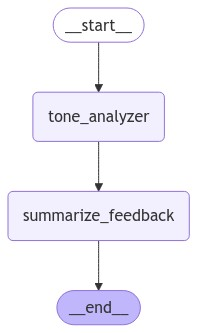

---Node 1 State--- {'text': 'The support team was very helpful, but I faced a delay in receiving my product. It arrived with minor damage.'}
Respose of tone analyzer node: The tone of the feedback is **mixed**. 

Here's a breakdown:

* **Positive:** "The support team was very helpful" indicates a positive experience with customer service.
* **Negative:** "I faced a delay in receiving my product" and "It arrived with minor damage" both express dissatisfaction with the product delivery and condition. 

**Overall:** While the customer acknowledges the helpfulness of the support team, the negative aspects of the delayed and damaged product outweigh the positive, making the overall sentiment leaning towards negative. 

---Node 2 State--- {'text': 'The support team was very helpful, but I faced a delay in receiving my product. It arrived with minor damage.', 'response': 'The tone of the feedback is **mixed**. \n\nHere\'s a breakdown:\n\n* **Positive:** "The support team was very helpful" ind

> The customer received helpful support but experienced a delayed delivery and minor damage to their product. 


In [ ]:
class State(TypedDict):
    text: str
    response: str

def tone_analyzer(state: State):
    print("---Node 1 State---", state)
    prompt = state["text"]
    system_message = f"Analyze the tone of this customer feedback: '{prompt}' and respond with whether it’s positive, neutral, or negative."

    ai_msg: AIMessage = llm.invoke(system_message)
    print(f"Respose of tone analyzer node: {ai_msg.content}")

    return {"text": prompt, "response": ai_msg.content}

def summarize_feedback(state):
    print("---Node 2 State---", state)
    prompt = state["text"]
    print(f"Prompt: {prompt}")
    system_message = f"Provide a concise summary of the main points in this customer feedback: '{prompt}'"

    ai_msg: AIMessage = llm.invoke(system_message)
    print(f"Respose of summarizer node: {ai_msg.content}")

    return {"text": prompt, "response": ai_msg.content}

# Building graph for the customer feedback analysis

builder: StateGraph = StateGraph(state_schema=State)

builder.add_node("tone_analyzer", tone_analyzer)
builder.add_node("summarize_feedback", summarize_feedback)

# Define the flow
builder.add_edge(START, "tone_analyzer")
builder.add_edge("tone_analyzer", "summarize_feedback")
builder.add_edge("summarize_feedback", END)

# Compile and visualize the graph
graph: CompiledStateGraph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

# Test the graph with an example feedback
result = graph.invoke({"text": "The support team was very helpful, but I faced a delay in receiving my product. It arrived with minor damage."})

to_markdown(result['response'])


Lets try another usecase

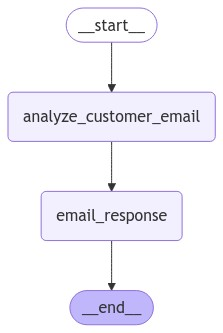

---Node 1 State--- {'email': 'Dear Customer Support Team,\n\nI hope this message finds you well. I am reaching out regarding my recent order, #[Order12345], placed on October 20th. I was initially informed that it would arrive within 5-7 business days, but it has now been over two weeks with no updates on the delivery status.\n\nAdditionally, when I attempted to track the package, I found that the tracking link provided was invalid. I understand there may be delays, but I would appreciate it if you could provide an update on the expected arrival date.\n\nIf possible, please advise if there’s anything further I need to do on my end. I would also appreciate information on any potential compensation or discounts for the delay.\n\nThank you very much for your assistance, and I look forward to hearing back soon.\n\nBest regards,\nEmily Thompson'}
Respose of email analyzer node: The tone of the email is **polite but firm**. Emily starts by expressing hope the support team is well, but quickl

> Subject: Re: Order #[Order12345] - Delivery Update
> 
> Dear Emily,
> 
> Thank you for reaching out and we apologize for the delay in your order #[Order12345]. We understand your frustration with the lack of updates and the invalid tracking link. 
> 
> We are currently experiencing some shipping delays due to [brief explanation of reason for delay, e.g.,  high order volume, weather conditions, etc.]. We are working diligently to get your order delivered as soon as possible.
> 
> We have investigated your order and can confirm that it is [current status of order, e.g.,  being processed, in transit, etc.]. We expect it to arrive on [estimated delivery date]. 
> 
> We will keep you updated on its progress and send you a new tracking link as soon as it becomes available.
> 
> We sincerely apologize for the inconvenience this has caused. As a gesture of goodwill, we would like to offer you [compensation or discount, e.g., a 10% discount on your next order, free shipping on your next order, etc.].
> 
> Please don't hesitate to contact us if you have any further questions.
> 
> Sincerely,
> 
> The [Company Name] Customer Support Team 


In [ ]:
class State(TypedDict):
    email: str
    response: str

def analyze_customer_email(state: State):
    print("---Node 1 State---", state)
    email = state["email"]

    system_message = f"Analyze the tone and the urgence of the user email {email}"
    ai_msg: AIMessage = llm.invoke(system_message)
    print(f"Respose of email analyzer node: {ai_msg.content}")
    return {"email": email, "response": ai_msg.content}

def email_response(state: State):
  print("---Node 2 State ---", state)
  analysis = state['email']

  system_message = f"Based on the tone and urgence of the user email {analysis}, write a response email"
  ai_msg: AIMessage = llm.invoke(system_message)
  print(f"Respose of email response node: {ai_msg.content}")

  return {"email": analysis, "response": ai_msg.content}

builder: StateGraph = StateGraph(state_schema=State)

builder.add_node("analyze_customer_email", analyze_customer_email)
builder.add_node("email_response", email_response)

builder.add_edge(START, "analyze_customer_email")
builder.add_edge('analyze_customer_email', 'email_response')
builder.add_edge('email_response', END)

graph: CompiledStateGraph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

user_email = """Dear Customer Support Team,

I hope this message finds you well. I am reaching out regarding my recent order, #[Order12345], placed on October 20th. I was initially informed that it would arrive within 5-7 business days, but it has now been over two weeks with no updates on the delivery status.

Additionally, when I attempted to track the package, I found that the tracking link provided was invalid. I understand there may be delays, but I would appreciate it if you could provide an update on the expected arrival date.

If possible, please advise if there’s anything further I need to do on my end. I would also appreciate information on any potential compensation or discounts for the delay.

Thank you very much for your assistance, and I look forward to hearing back soon.

Best regards,
Emily Thompson"""

result = graph.invoke({"email": user_email})

to_markdown(result['response'])


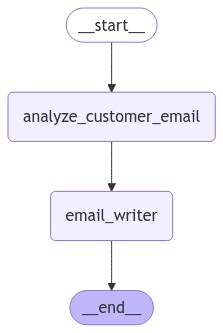

---Node 1 State--- {'email': 'Dear Customer Support Team,\nI hope this message finds you well. I am reaching out regarding my recent order, #[Order12345], placed on October 20th. I was initially informed that it would arrive within 5-7 business days, but it has now been over two weeks with no updates on the delivery status.\nAdditionally, when I attempted to track the package, I found that the tracking link provided was invalid. I understand there may be delays, but I would appreciate it if you could provide an update on the expected arrival date.\nIf possible, please advise if there’s anything further I need to do on my end. I would also appreciate information on any potential compensation or discounts for the delay.\nThank you very much for your assistance, and I look forward to hearing back soon.\nBest regards,\nEmily Thompson\n'}
Respose of email analyzer node: The tone of the email is **polite but firm**. The user starts by expressing hope that the customer support team is well, w

> Subject: Re: Order #[Order12345] - Delivery Update
> 
> Dear Emily,
> 
> Thank you for contacting us regarding your order #[Order12345]. We apologize for the delay in your order and the inconvenience this has caused. 
> 
> We understand your frustration, and we are actively investigating the reason for the delay. The tracking link you were provided was indeed invalid, and we are working to rectify that. 
> 
> We will provide you with an updated estimated delivery date as soon as possible. We are also looking into the possibility of offering compensation for the delay and will keep you informed of any options available. 
> 
> In the meantime, please rest assured that we are doing everything we can to get your order to you as quickly as possible.
> 
> Thank you for your patience and understanding.
> 
> Sincerely,
> 
> [Your Company Name] Customer Support Team 


In [ ]:
class State(TypedDict):
    email: str
    response: str

def analyze_customer_email(state: State)->State:
  print("---Node 1 State---", state)
  email = state["email"]
  prompt: str = f"Analyze the tone and the urgence of the user email {email}"
  ai_response: AIMessage = llm.invoke(prompt)
  print(f"Respose of email analyzer node: {ai_response.content}")
  return {"email": email, "response": ai_response.content}


def email_writer(state: State)->State:
  print("---Node 2 State ---", state)
  email = state["email"]
  prompt: str = f"Based on the tone and urgence of the user email {email}, write a response email"
  ai_response: AIMessage = llm.invoke(prompt)
  return {"email": email, "response": ai_response.content}

builder: StateGraph = StateGraph(state_schema=State)

builder.add_node("analyze_customer_email", analyze_customer_email)
builder.add_node("email_writer", email_writer)

builder.add_edge(START, "analyze_customer_email")
builder.add_edge("analyze_customer_email", "email_writer")
builder.add_edge("email_writer", END)

graph: CompiledStateGraph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

user_email = """Dear Customer Support Team,
I hope this message finds you well. I am reaching out regarding my recent order, #[Order12345], placed on October 20th. I was initially informed that it would arrive within 5-7 business days, but it has now been over two weeks with no updates on the delivery status.
Additionally, when I attempted to track the package, I found that the tracking link provided was invalid. I understand there may be delays, but I would appreciate it if you could provide an update on the expected arrival date.
If possible, please advise if there’s anything further I need to do on my end. I would also appreciate information on any potential compensation or discounts for the delay.
Thank you very much for your assistance, and I look forward to hearing back soon.
Best regards,
Emily Thompson
"""
result = graph.invoke({"email": user_email})

to_markdown(result['response'])

## Conditional Edges

By default, the new value return by each node will override the prior state value. We will create hard-coded logic to demonstrate the workflow in conditional edges

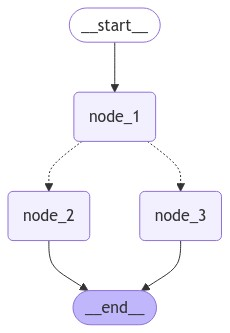

In [ ]:
class State(TypedDict):
    user_input: str

def node_1(state: State) -> State:
    print("---Node 1 State---", state)
    return {"user_input": state["user_input"] + "I am"}

def node_2(state: State) -> State:
  print("---Node 2 State---", state)
  return {"user_input": state["user_input"] + " happy!"}

def node_3(state: State) -> State:
  print("---Node 3 State---", state)
  return {"user_input": state["user_input"] + " I sad"}

number: float = random.random()

def decide_node(state:State) ->Literal["node_2", "node_3"]:
  user_input = state["user_input"]

  if random.random() < 0.5:
    return "node_2"
  else:
    return "node_3"

builder: StateGraph = StateGraph(state_schema=State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_node)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for i in range(3):
  result = graph.invoke({"user_input": "Hi! I am Maaz "})
  print(result)
  print("")

---Node 1 State--- {'user_input': 'Hi! I am Maaz '}
---Node 2 State--- {'user_input': 'Hi! I am Maaz I am'}
{'user_input': 'Hi! I am Maaz I am happy!'}

---Node 1 State--- {'user_input': 'Hi! I am Maaz '}
---Node 3 State--- {'user_input': 'Hi! I am Maaz I am'}
{'user_input': 'Hi! I am Maaz I am I sad'}

---Node 1 State--- {'user_input': 'Hi! I am Maaz '}
---Node 3 State--- {'user_input': 'Hi! I am Maaz I am'}
{'user_input': 'Hi! I am Maaz I am I sad'}



### Examples

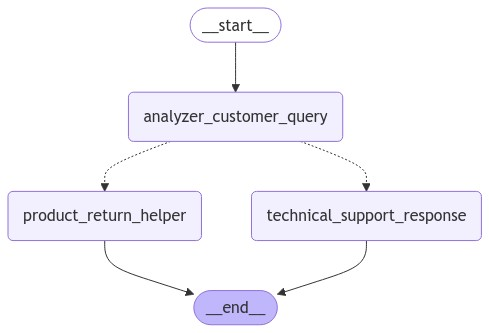

In [ ]:
class State(TypedDict):
    query: str
    response: str

def analyzer_customer_query(state: State)->State:
  print("---Node 1 State---", state)
  query = state["query"]
  prompt = f"""Analyze the user query {query} and select which department to route the query to.
                  The departments are technical support and product return.
              """
  ai_response = llm.invoke(prompt)
  department = ai_response.content.strip().lower()
  print(f"Response of customer query analyzer node: {department}")
  return {"query": query, "response": department}

def technical_support_response(state: State)->State:
  print("---Node 2 State ---", state)
  query = state["query"]
  prompt = f"You are a technical support agent. Introduce yourself and respond to the user query {query} appropriately"
  ai_response = llm.invoke(prompt)
  return {"query": query, "response": ai_response.content}

def product_return_helper(state: State)->State:
  print("---Node 2 State ---", state)
  query = state["query"]
  prompt = f"You are a product return guiding agent. Introduce yourself and respond to the user query {query} appropriately"
  ai_response = llm.invoke(prompt)
  return {"query": query, "response": ai_response.content}

def deciding_node(state: State) -> Literal["technical_support_response", "product_return_helper"]:
  print("---Node 3 State ---", state)
  department = state["response"]
  print(f"Deciding node based on department: {department}")
  if department == "technical support":
      return "technical_support_response"
  else:
      return "product_return_helper"

builder: StateGraph = StateGraph(state_schema=State)

builder.add_node("analyzer_customer_query", analyzer_customer_query)
builder.add_node("technical_support_response", technical_support_response)
builder.add_node("product_return_helper", product_return_helper)

builder.add_edge(START, "analyzer_customer_query")
builder.add_conditional_edges("analyzer_customer_query", deciding_node)
builder.add_edge("technical_support_response", END)
builder.add_edge("product_return_helper", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"query": "I want to return the laptop I bought"})
to_markdown(result['response'])

---Node 1 State--- {'query': 'I want to return the laptop I bought'}
Response of customer query analyzer node: ## analysis of user query:

the user query "i want to return the laptop i bought" indicates a **product return request**. 

**reasoning:**

* **"i want to return..."**: this phrase explicitly states the user's intent to return a product.
* **"...the laptop i bought"**: this clarifies the specific product being returned. 

**department routing:**

based on the analysis, the query should be routed to the **product return** department.

**why not technical support?**

while technical support may be involved in resolving issues with a product, the query doesn't indicate any technical problems. the user wants to return the product, which is a process handled by the product return department.
---Node 3 State --- {'query': 'I want to return the laptop I bought', 'response': '## analysis of user query:\n\nthe user query "i want to return the laptop i bought" indicates a **product retu

> Hello! I'm here to help you with your product return.  Can you tell me a bit more about the laptop you'd like to return?  For example,  
> 
> * **Where did you purchase the laptop?** (Online, in-store, etc.)
> * **When did you purchase the laptop?** (Date of purchase)
> * **What is the make and model of the laptop?** (e.g., Dell XPS 13)
> * **What is the reason for the return?** (Defective, wrong item, change of mind, etc.)
> 
> Once I have this information, I can guide you through the return process and provide you with the necessary details. 


In [ ]:
result = graph.invoke({"query": "The printer is not responding. Can you help?"})
to_markdown(result['response'])

---Node 1 State--- {'query': 'The printer is not responding. Can you help?'}
Response of customer query analyzer node: the query "the printer is not responding. can you help?" should be routed to **technical support**. 

here's why:

* **technical support** deals with issues related to the functionality and operation of products. a non-responsive printer indicates a technical problem.
* **product return** is for situations where a product is faulty or defective and needs to be replaced. while a non-responsive printer could be a sign of a faulty product, it's more likely a technical issue that can be resolved through troubleshooting.
---Node 3 State --- {'query': 'The printer is not responding. Can you help?', 'response': 'the query "the printer is not responding. can you help?" should be routed to **technical support**. \n\nhere\'s why:\n\n* **technical support** deals with issues related to the functionality and operation of products. a non-responsive printer indicates a technical pro

> Hi there! I'm your friendly product return guide, here to help you troubleshoot any issues you might be having. 
> 
> "The printer is not responding" -  That can be frustrating!  Let's see if we can fix it. Could you tell me a little more about what's happening? 
> 
> * **What kind of printer is it?** (Brand and model number would be helpful) 
> * **What are you trying to print?** (A document, a photo, etc.)
> * **Have you tried restarting the printer?** 
> * **Are you connected to the printer wirelessly or through a USB cable?** 
> * **Have you checked the power cable to make sure it's securely plugged in?**
> 
> Once I have a bit more information, I can give you some specific troubleshooting steps. 


## Tool Message

In [ ]:
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


Tools are useful whenever you want a model to interact with external systems. External systems (APIs etc) requires a particular input schema or payload rather than natural language

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [ ]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

In [ ]:
# checking current temperature using llm without tooks
result = llm.invoke("What is current temperature in London?")
print(f"Response without tools: {result.content}")

# checking temperature using llm with tools
result = tool.invoke("What is temperature in London?", llm=llm)
for r in result:
    print(f"Response with tools: {r['content']}")

Response without tools: I do not have access to real-time information, including weather data. To get the current temperature in London, I recommend checking a reliable weather website or app. 

Response with tools: That's Not What Was Expected
Outside
Avalanche Hits Highway
2023 Was Out Of This World
'Heart Attack Snow'
Start 2024 With Less Stress
Stay Safe
Air Quality Index
Air quality is considered satisfactory, and air pollution poses little or no risk.
 recents
Specialty Forecasts
10 Day Weather-London, England, United Kingdom
Tonight
Mon 15 | Night
Partly cloudy early followed by cloudy skies overnight. Don't Miss
Radar
Begin With Breathing
House Warming Hacks
 High 52F. Winds SW at 10 to 15 mph.
 High 52F. Winds SW at 10 to 15 mph.

Response with tools: Sun & Moon. Weather Today Weather Hourly 14 Day Forecast Yesterday/Past Weather Climate (Averages) Currently: 57 °F. Passing clouds. (Weather station: Northolt, United Kingdom). See more current weather.


## Agent

In [ ]:
def multiply(a: int, b: int) -> int:
  """ Multiply a and b"""
  return a * b

def add(a: int, b: int) -> int:
  """ Add a and b"""
  return a + b

def divide(a: int, b: int)-> int:
  """Divide a and b"""
  return a / b;

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash',
                             api_key=os.environ.get('GOOGLE_API_KEY')
                            )
llm_with_tools = llm.bind(tools=tools)

In [ ]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs")

def assistant(state: MessagesState) -> MessagesState:
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

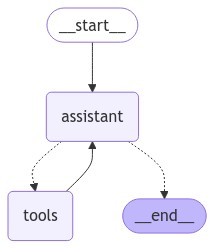

In [ ]:
builder: StateGraph = StateGraph(state_schema=MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")

react_graph: CompiledStateGraph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

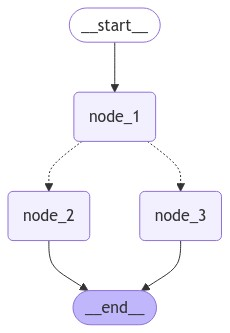

In [ ]:
# dataclass offer a concise syntax for creating classes that are primarily used to store data
# however, it doesn't enfore types at runtime
@dataclass
class DataclassState:
  name: str
  mood: Literal["happy", "sad"]

def node_1(state: DataclassState) -> DataclassState:
    print("---Node 1 State---", state)
    return {"name": state.name + " is ..."}

def node_2(state: DataclassState) -> DataclassState:
  print("---Node 2 State---", state)
  return {"name": state.name + " happy!"}

def node_3(state: DataclassState) -> DataclassState:
  print("---Node 3 State---", state)
  return {"name": state.name + " sad"}

def decide_mood(state: DataclassState) -> Literal["node_2", "node_3"]:

    if random.random() < 0.5:

        return "node_2"

    return "node_3"

builder: StateGraph = StateGraph(DataclassState)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
class PydanticState(BaseModel):
    name: str
    mood: Literal["happy", "sad"]

    @field_validator("name")
    @classmethod
    def name_must_contain_space(cls, value):
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

try:
  state = PydanticState(name="happy", mood="mad")
except ValidationError as e:
  print(f"Validation error: {e}")

Validation error: 1 validation error for PydanticState
mood
  Input should be 'happy' or 'sad' [type=literal_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/literal_error


### Pydnatic React Agent

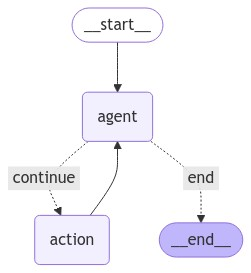

In [ ]:
@tool
def search(query: str) -> str:
  """CAll to surf the web"""
  return "The answer to your question lies within"

tools = [search] #list of tools intended to be use by agent
tool_node: ToolNode = ToolNode(tools) #ToolNode is a class that acts as a container
                              # or wrapper for tools, managing how and when they're
                              # called within the workflow. By using ToolNode, you
                              # can define a set of tools that can be used within
                              # a workflow graph

class AgentState(BaseModel):
  messages: Annotated[Sequence[BaseMessage], operator.add] #Annoted is used to provide
          #more information about the messages field. This line of code means that
          # nessage is a sequence of base message object. The operator.add acts as
          # a metadata for the ANnotated type and indicates that the messages field
          # should behave like a list where you can append new BaseMessage objects

def should_continue(state: AgentState) -> Literal["end", "continue"]:
    messages = state.messages # get the messages
    last_message = messages[-1] # get the last message
    if not last_message.tool_calls: # returns end if the last message triggered any tool call or else continue
        return "end"
    else:
        return "continue"

# a function that takes agent messages in the agent state and pass it to the llm for processing and return response
def call_model(state: AgentState):
    llm_with_tools = gemini.bind_tools(tools=tools)
    messages = state.messages
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


workflow: StateGraph = StateGraph(AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
                                  "agent",
                                  should_continue,
                                  {
                                      "continue": "action",
                                      "end": END,
                                  },
                              )
workflow.add_edge("action", "agent")


app: CompiledStateGraph = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
for chunk in app.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  search (86155251-c23e-40b6-a074-950f9512b00c)
 Call ID: 86155251-c23e-40b6-a074-950f9512b00c
  Args:
    query: weather in sf
================================= Tool Message =================================
Name: search

The answer to your question lies within
================================== Ai Message ==================================

I am sorry, I cannot fulfill this request. The available tools lack the desired functionality.
